In [2]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 18.9 MB/s eta 0:00:00


In [4]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
from google.colab import files
files.upload()


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d unmoved/30k-cats-and-dogs-150x150-greyscale

!unzip 30k-cats-and-dogs-150x150-greyscale.zip -d data/


Saving archive.zip to archive.zip
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open 30k-cats-and-dogs-150x150-greyscale.zip, 30k-cats-and-dogs-150x150-greyscale.zip.zip or 30k-ca

In [7]:
!unzip /content/archive.zip -d /content/extracted_data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted_data/Animal Images/dogs/dog.441.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4410.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4411.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4412.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4413.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4414.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4415.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4416.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4417.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4418.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4419.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.442.jpg  
  inflating: /content/extracted_data/Animal Images/dogs/dog.4420.jpg  
  inflating: /content/extrac

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_images(folder, label):
    images, labels = [], []
    for img_name in os.listdir(folder):
        try:
            img = cv2.imread(os.path.join(folder, img_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (80, 80))
            images.append(img)
            labels.append(label)
        except:
            continue
    return images, labels

cat_images, cat_labels = load_images('/content/extracted_data/Animal Images/cats', 0)
dog_images, dog_labels = load_images('/content/extracted_data/Animal Images/dogs', 1)

X = np.array(cat_images + dog_images).reshape(-1, 80, 80, 1) / 255.0
y = np.array(cat_labels + dog_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# ✅ STEP 4: 4-layer DNN with LR scheduler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    return 1e-3 if epoch < 5 else 5e-3

model_dnn_4 = Sequential([
    Flatten(input_shape=(80, 80, 1)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_dnn_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_4 = model_dnn_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, callbacks=[LearningRateScheduler(lr_schedule)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.4965 - loss: 0.7458 - val_accuracy: 0.5059 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.4962 - loss: 0.6932 - val_accuracy: 0.5059 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5059 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5060 - loss: 0.6931 - val_accuracy: 0.4941 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 5/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.4999 - loss: 0.6931 - val_accuracy: 0.5059 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.4957 - loss: 0.6933 - val_accuracy: 0.4941 - val_loss: 0.6937 - learning_rate: 0.0050
Epoch 7/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.4990 - l

In [11]:
# ✅ STEP 5: 6-layer DNN
model_dnn_6 = Sequential([
    Flatten(input_shape=(80, 80, 1)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_dnn_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_6 = model_dnn_6.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15)

Epoch 1/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.5026 - loss: 0.7184 - val_accuracy: 0.4939 - val_loss: 0.6939
Epoch 2/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.4992 - loss: 0.6935 - val_accuracy: 0.5059 - val_loss: 0.6931
Epoch 3/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.5059 - val_loss: 0.6931
Epoch 4/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.4959 - loss: 0.6933 - val_accuracy: 0.4988 - val_loss: 0.6931
Epoch 5/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5055 - loss: 0.6932 - val_accuracy: 0.5059 - val_loss: 0.6931
Epoch 6/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.4912 - loss: 0.6933 - val_accuracy: 0.5059 - val_loss: 0.6931
Epoch 7/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.5033 - loss: 0.6931 - val_accuracy: 0.4941 - val_loss: 0.6932
Epoch 8/15
752/752 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.5022 - loss: 0.6933 - 

4-Layer DNN Results:
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


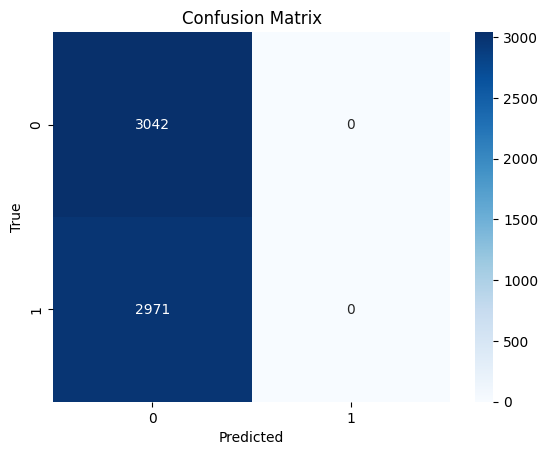

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.51      1.00      0.67      3042
           1       0.00      0.00      0.00      2971

    accuracy                           0.51      6013
   macro avg       0.25      0.50      0.34      6013
weighted avg       0.26      0.51      0.34      6013

6-Layer DNN Results:
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


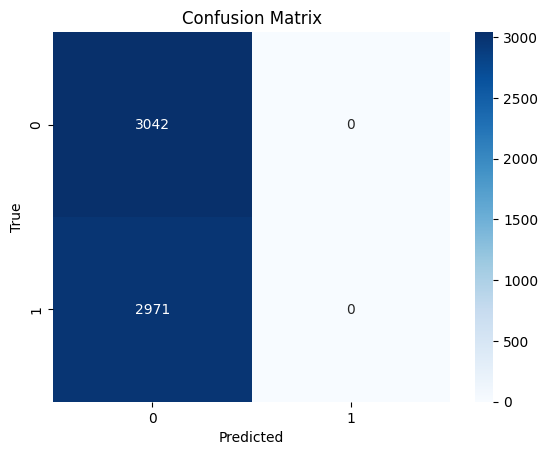

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      3042
           1       0.00      0.00      0.00      2971

    accuracy                           0.51      6013
   macro avg       0.25      0.50      0.34      6013
weighted avg       0.26      0.51      0.34      6013



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# ✅ STEP 6: Evaluation with Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_test, y_pred))

print("4-Layer DNN Results:")
evaluate_model(model_dnn_4, X_test, y_test)

print("6-Layer DNN Results:")
evaluate_model(model_dnn_6, X_test, y_test)